<a href="https://www.kaggle.com/code/markstent/supermarket-data-eda-kmeans?scriptVersionId=128436448" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-dataset-for-predictive-marketing-2023/ECommerce_consumer behaviour.csv


In [2]:
#KElbowvisualizer requires < 1.23 for Numpy
!pip install numpy==1.22.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 67.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
cuml 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
cudf 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow-serving-api 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
raft-dask 23.4.0 requires dask==2023.3.2, but you have dask 2023.4.0 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you h

# Import the relevant libraries

In [3]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler, normalize
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Import the data

Make a copy of the data for backup and show the first 5 rows of the dataframe

In [4]:
data = pd.read_csv("/kaggle/input/ecommerce-dataset-for-predictive-marketing-2023/ECommerce_consumer behaviour.csv")
data_copy = data.copy()
data.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id,department,product_name
0,2425083,49125,1,2,18,NaN,17,1,0,13,pantry,baking ingredients
1,2425083,49125,1,2,18,NaN,91,2,0,16,dairy eggs,soy lactosefree
2,2425083,49125,1,2,18,NaN,36,3,0,16,dairy eggs,butter
3,2425083,49125,1,2,18,NaN,83,4,0,4,produce,fresh vegetables
4,2425083,49125,1,2,18,NaN,83,5,0,4,produce,fresh vegetables


# Basic dataframe EDA

In [5]:
data.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id
count,2.019501e+06,2.019501e+06,2.019501e+06,2.019501e+06,2.019501e+06,1.895159e+06,2.019501e+06,2.019501e+06,2.019501e+06,2.019501e+06
mean,1.707013e+06,1.030673e+05,1.715138e+01,2.735367e+00,1.343948e+01,1.138603e+01,7.120590e+01,8.363173e+00,5.897427e-01,9.928349e+00
std,9.859832e+05,5.949117e+04,1.752576e+01,2.093882e+00,4.241008e+00,8.970980e+00,3.820727e+01,7.150059e+00,4.918804e-01,6.282933e+00
min,1.000000e+01,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
25%,8.526490e+05,5.158400e+04,5.000000e+00,1.000000e+00,1.000000e+01,5.000000e+00,3.100000e+01,3.000000e+00,0.000000e+00,4.000000e+00
50%,1.705004e+06,1.026900e+05,1.100000e+01,3.000000e+00,1.300000e+01,8.000000e+00,8.300000e+01,6.000000e+00,1.000000e+00,9.000000e+00
75%,2.559031e+06,1.546000e+05,2.400000e+01,5.000000e+00,1.600000e+01,1.500000e+01,1.070000e+02,1.100000e+01,1.000000e+00,1.600000e+01
max,3.421080e+06,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01,1.340000e+02,1.370000e+02,1.000000e+00,2.100000e+01


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019501 entries, 0 to 2019500
Data columns (total 12 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   order_number            int64  
 3   order_dow               int64  
 4   order_hour_of_day       int64  
 5   days_since_prior_order  float64
 6   product_id              int64  
 7   add_to_cart_order       int64  
 8   reordered               int64  
 9   department_id           int64  
 10  department              object 
 11  product_name            object 
dtypes: float64(1), int64(9), object(2)
memory usage: 184.9+ MB


# How many unique departments are there?

In [7]:
data['department_id'].nunique()

21

# How many unique products are there?

In [8]:
data['product_id'].nunique()

134

# How many unique users are there?

In [9]:
data['user_id'].nunique()

105273

In [10]:
data.isna().sum()

order_id                       0
user_id                        0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    124342
product_id                     0
add_to_cart_order              0
reordered                      0
department_id                  0
department                     0
product_name                   0
dtype: int64

In [11]:
#fill days since prior order with 0 as there cannot be negative values
data.fillna(0, inplace=True)

# **What is the average number of items placed in the basket?**

In [12]:
data['add_to_cart_order'].mean()

8.363173377978026

# **How long are customers waiting before ordering again on average?**

In [13]:
data['days_since_prior_order'].mean()

10.684989014613016

# **What time of day is busiest?**

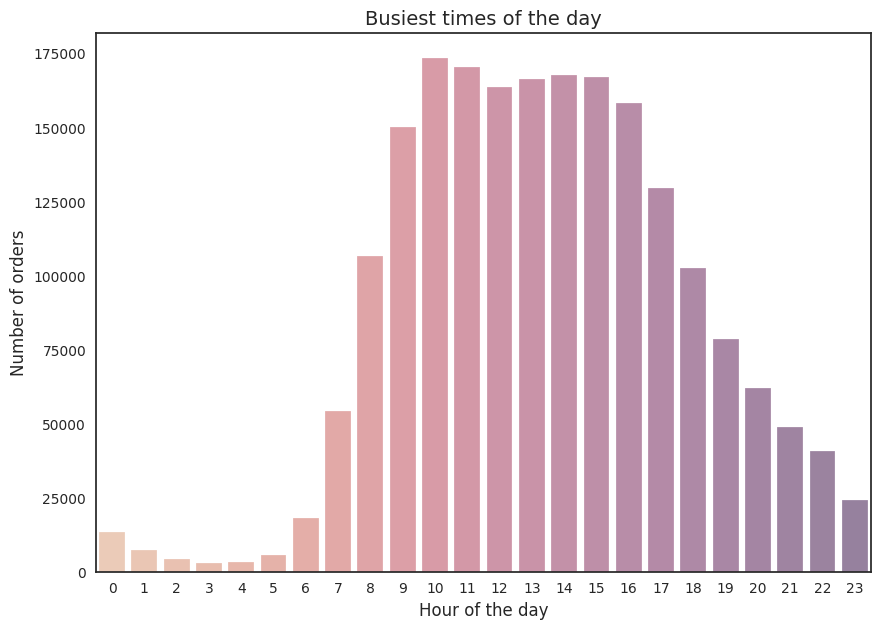

In [14]:
data['order_hour_of_day'].value_counts()

plt.figure(figsize = (10,7))
sns.set_style("ticks")
sns.countplot(data=data, x=data['order_hour_of_day'], palette = 'flare', alpha=0.6)
plt.title("Busiest times of the day", fontsize=14)
plt.xlabel("Hour of the day", fontsize=12)
plt.ylabel("Number of orders", fontsize=12)
plt.show()

# **What are the most popular departments?**

In [15]:
departments = data['department'].value_counts()

departments_df = pd.DataFrame(departments).reset_index()

departments_df.columns = ['Department', 'Order Count']

top_departments = departments_df.sort_values(by='Order Count', ascending=False).head()

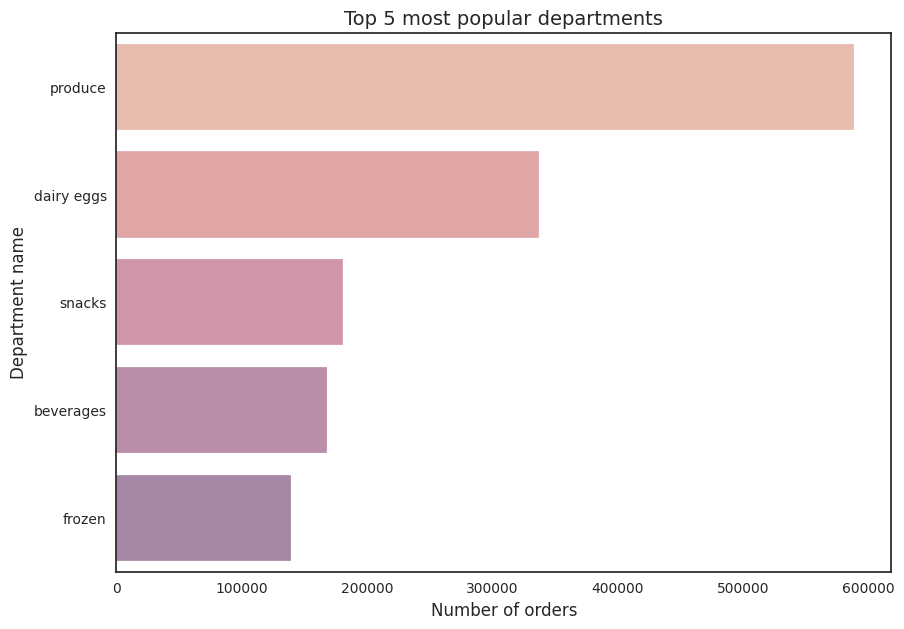

In [16]:
plt.figure(figsize = (10,7))
sns.set_style("ticks")
sns.barplot(data=top_departments, x="Order Count", y="Department", palette = 'flare', alpha=0.6)
plt.title("Top 5 most popular departments", fontsize=14)
plt.xlabel("Number of orders", fontsize=12)
plt.ylabel("Department name", fontsize=12)
plt.show()

# **What are the most popular products?**

In [17]:
products = data['product_name'].value_counts()

products_df = pd.DataFrame(products).reset_index()

products_df.columns = ['Product', 'Order Count']

top_products = products_df.sort_values(by='Order Count', ascending=False).head()

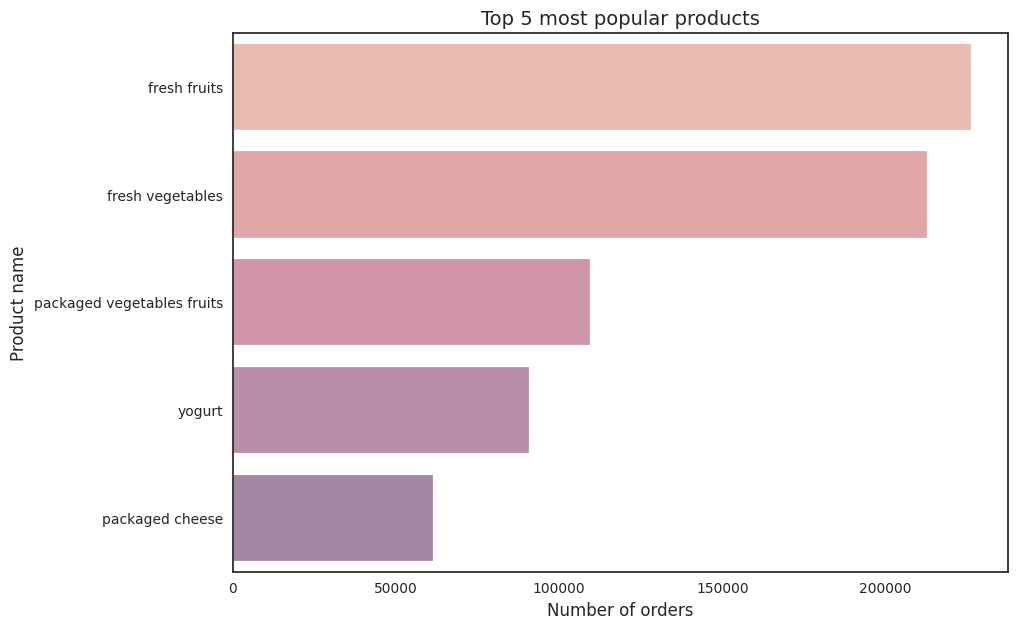

In [18]:
plt.figure(figsize = (10,7))
sns.set_style("ticks")
sns.barplot(data=top_products, x="Order Count", y="Product", palette = 'flare', alpha=0.6)
plt.title("Top 5 most popular products", fontsize=14)
plt.xlabel("Number of orders", fontsize=12)
plt.ylabel("Product name", fontsize=12)
plt.show()

In [19]:
data.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id,department,product_name
0,2425083,49125,1,2,18,0.0,17,1,0,13,pantry,baking ingredients
1,2425083,49125,1,2,18,0.0,91,2,0,16,dairy eggs,soy lactosefree
2,2425083,49125,1,2,18,0.0,36,3,0,16,dairy eggs,butter
3,2425083,49125,1,2,18,0.0,83,4,0,4,produce,fresh vegetables
4,2425083,49125,1,2,18,0.0,83,5,0,4,produce,fresh vegetables


In [20]:
# Crosstab to check distribution of products in each department
product_dept_df = pd.crosstab(data['department'], data['product_name'])
product_dept_df.head()

product_name,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
department,,,,,,,,,,,,,,,,,,,,,
alcohol,0,0,0,0,0,0,0,0,0,3002,...,0,0,0,0,0,0,0,0,1893,0
babies,0,0,504,515,23355,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bakery,0,0,0,0,0,2214,0,0,0,0,...,0,0,0,12082,0,0,0,0,0,0
beverages,0,0,0,0,0,0,0,0,0,0,...,0,15733,0,0,0,0,0,52564,0,0
breakfast,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# What is the most popular product in each category?

In [21]:
product_dept_df.idxmax(axis=1).to_frame(name="Most popular Item")

,Most popular Item
department,
alcohol,beers coolers
babies,baby food formula
bakery,bread
beverages,water seltzer sparkling water
breakfast,cereal
bulk,bulk grains rice dried goods
canned goods,soup broth bouillon
dairy eggs,yogurt
deli,lunch meat


# **Which products are reordered most?**

In [22]:
product_reordered_df = data.groupby('product_name')['reordered'].count().reset_index().sort_values(by='reordered', ascending=False)
product_reordered_df

,product_name,reordered
50,fresh fruits,226039
53,fresh vegetables,212611
98,packaged vegetables fruits,109596
133,yogurt,90751
93,packaged cheese,61502
...,...,...
76,kitchen supplies,561
3,baby bath body care,515
2,baby accessories,504
8,beauty,387


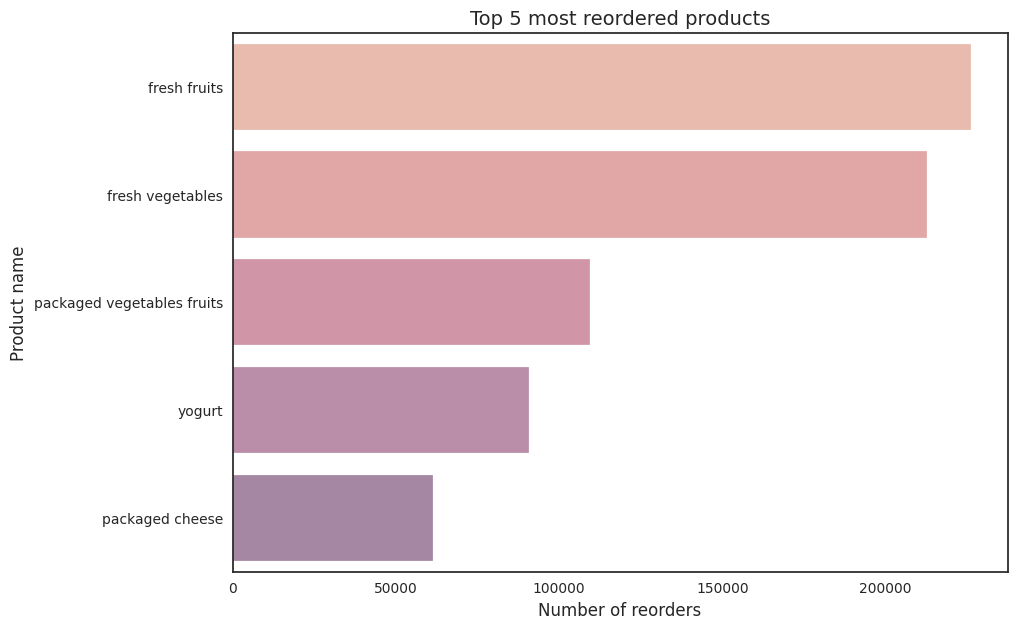

In [23]:
plt.figure(figsize = (10,7))
sns.set_style("ticks")
sns.barplot(data=product_reordered_df.head(5), x="reordered", y="product_name", palette = 'flare', alpha=0.6)
plt.title("Top 5 most reordered products", fontsize=14)
plt.xlabel("Number of reorders", fontsize=12)
plt.ylabel("Product name", fontsize=12)
plt.show()

In [24]:
# Create a dataframe to save the departments

data_departments = data['department']

#drop columns that have no signal
data.drop(['order_id', 'user_id', 'order_number','product_id', 'department_id', 'department'], axis=1, inplace=True)

In [25]:
data.head()

,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,product_name
0,2,18,0.0,1,0,baking ingredients
1,2,18,0.0,2,0,soy lactosefree
2,2,18,0.0,3,0,butter
3,2,18,0.0,4,0,fresh vegetables
4,2,18,0.0,5,0,fresh vegetables


# KMeans Cluster analysis

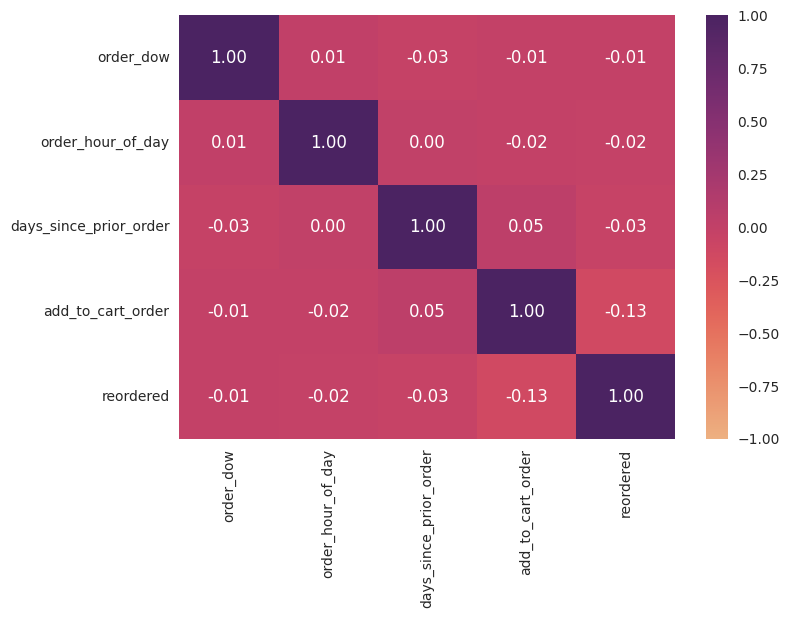

In [26]:
#check for any correlations in the dataset

sns.heatmap(data.iloc[:, :-1].corr(), 
            annot=True,
            vmin=-1,
            vmax=1,
            cmap='flare',
            fmt='.2f')
plt.show()

In [27]:
#scale the data

scaler = StandardScaler()

data_scaled = scaler.fit_transform(data.iloc[:, :-1])

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x76f58f6aa950>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 584, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 725, in _make_controller_from_path
    lib_controller = lib_controller_class(
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 842, in __init__
    super().__init__(**kwargs)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 810, in __init__
    self._dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/opt/conda/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /opt/conda/lib/python3.10/site-packages/numpy.libs/libopenblas64_p-r0-742d56dc.3.20.so: cann

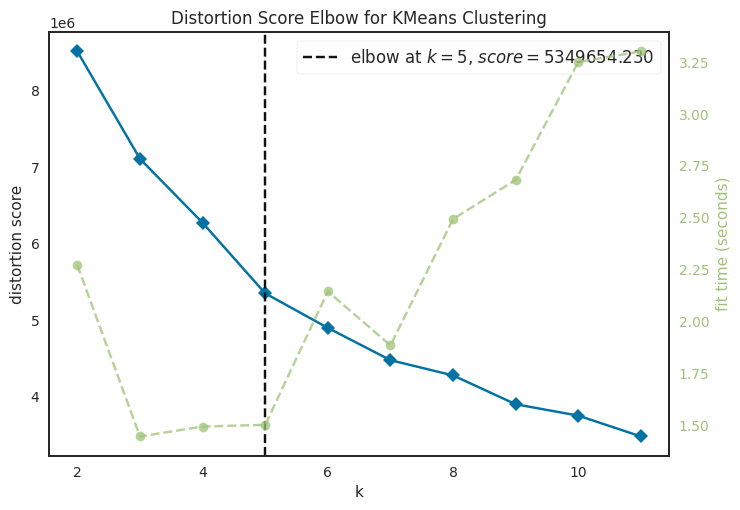

In [28]:
#check for number of optimal clusters

model = KMeans(n_init='auto')
visualiser = KElbowVisualizer(model, k=(2,12))
visualiser.fit(data_scaled)        
visualiser.show();

In [29]:
#fit the model with 5 clusters

kmeans_mod = KMeans(n_clusters=5, n_init='auto')
kmeans_mod.fit(data_scaled)

KMeans(n_clusters=5, n_init='auto')

In [30]:
data['cluster'] = kmeans_mod.labels_
data.head()

,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,product_name,cluster
0,2,18,0.0,1,0,baking ingredients,3
1,2,18,0.0,2,0,soy lactosefree,3
2,2,18,0.0,3,0,butter,3
3,2,18,0.0,4,0,fresh vegetables,3
4,2,18,0.0,5,0,fresh vegetables,3


In [31]:
data['cluster'].value_counts()

3    544694
1    484147
0    477413
2    323217
4    190030
Name: cluster, dtype: int64

In [32]:
# add back the departments column

data_with_dept = pd.concat([data, data_departments], axis=1)
data_with_dept.head()

,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,product_name,cluster,department
0,2,18,0.0,1,0,baking ingredients,3,pantry
1,2,18,0.0,2,0,soy lactosefree,3,dairy eggs
2,2,18,0.0,3,0,butter,3,dairy eggs
3,2,18,0.0,4,0,fresh vegetables,3,produce
4,2,18,0.0,5,0,fresh vegetables,3,produce


# PCA

In [33]:
data.head()

,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,product_name,cluster
0,2,18,0.0,1,0,baking ingredients,3
1,2,18,0.0,2,0,soy lactosefree,3
2,2,18,0.0,3,0,butter,3
3,2,18,0.0,4,0,fresh vegetables,3
4,2,18,0.0,5,0,fresh vegetables,3


In [34]:
pca_mod = PCA(n_components=5)

# fit the PCA model to the (scaled) features
pca_mod.fit(data.iloc[:, :-2])

PCA(n_components=5)

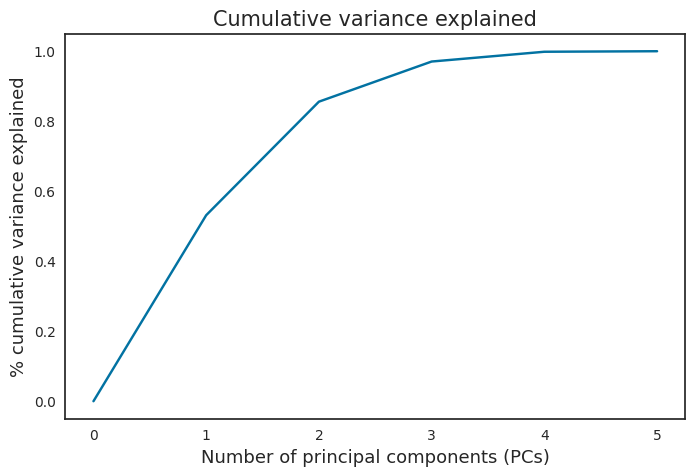

In [35]:
# plot the cumulative variance explained across all the components
# start the explained variance at 0
exp_variance = np.insert(pca_mod.explained_variance_ratio_, 0, 0)

# plot the explained variance
figure = plt.figure(figsize=(8, 5))

plt.plot(np.cumsum(exp_variance))
plt.xticks(range(0,6))
plt.xlabel("Number of principal components (PCs)", size=13)
plt.ylabel("% cumulative variance explained", size=13)
plt.title("Cumulative variance explained", size=15)

plt.show()

It looks like 3 compeonents are getting more than 95 percent of the variance in the model.

In [36]:
pca_mod = PCA(n_components=3)

data_pca = pd.DataFrame(data=pca_mod.fit_transform(data_scaled),
                        columns=['PC1', 'PC2', 'PC3'])

# view data frame of PCs
data_pca.head()

,PC1,PC2,PC3
0,-0.278378,-0.999085,-0.730310
1,-0.184500,-1.003332,-0.703474
2,-0.090622,-1.007578,-0.676637
3,0.003255,-1.011824,-0.649800
4,0.097133,-1.016071,-0.622963


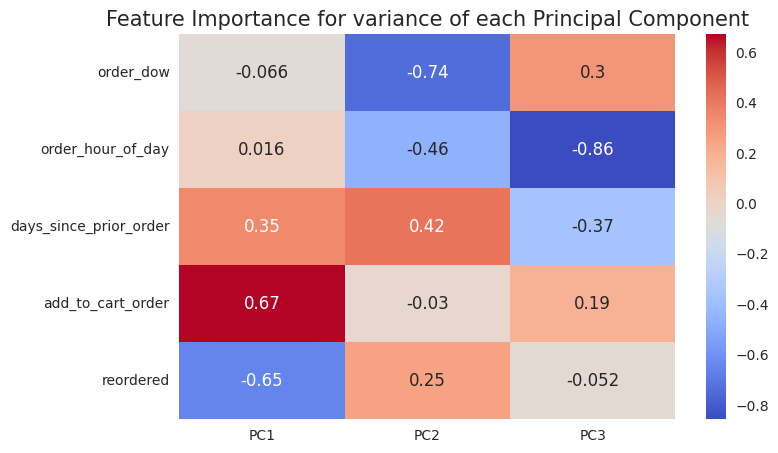

In [37]:
# feature importance for each component
figure = plt.figure(figsize=(8, 5))

sns.heatmap(pd.DataFrame(pca_mod.components_).transpose(),
            annot=True,
            # TASK: update the tick labels depending on your choice for the number of PCs
            xticklabels=['PC1', 'PC2', 'PC3'],
            yticklabels=data.iloc[:,:-2].columns,
            cmap='coolwarm')

plt.title('Feature Importance for variance of each Principal Component', fontsize=15)
plt.show()

* PC1 are mostly customers that reorder and order a large number of items at each order
* PC2 are influenced mostly by the day of the week
* PC3 are influenced by the hour of the day

# Plot the PCA data with the Clusters from the Kmeans 

In [38]:
# combine data for plotting
data.reset_index(drop=True, inplace=True)
data_pca.reset_index(drop=True, inplace=True)
plot_data = pd.concat([data_pca, data['cluster']], axis=1)

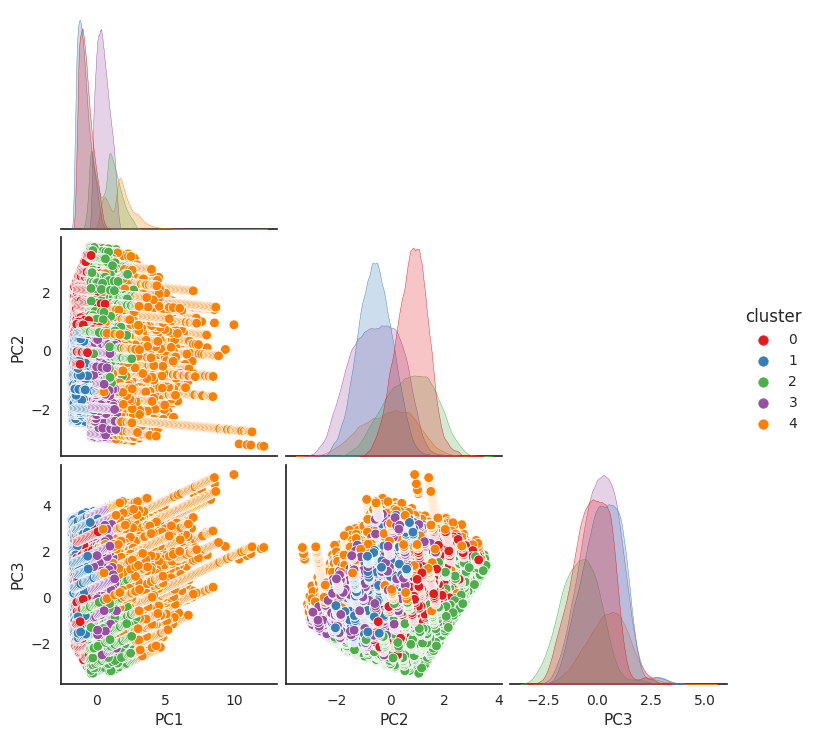

In [39]:
# visualise the clusters by plotting the PCAs in a scatter/pair plot, 
# with points colored by cluster membership
sns.pairplot(data=plot_data,
             hue='cluster',
             palette='Set1', 
             corner=True);